## A temperature forecasting problem

- Data: weather timeseries dataset recorded at the Weather Station at the Max-Planck-Institute for Biogeochemistry in Jena, Germany. Downloaded from here: https://www.bgc-jena.mpg.de/wetter/.

- In this dataset, 21 different quantities (such air temperature, atmospheric
pressure, humidity, wind direction, etc.) are recorded every ten minutes each year. This dataset is perfect for learning to work with numerical timeseries. We will use it to build a model that takes as input some data from the recent past (a few days worth of data points) and predicts the air temperature 24 hours in the future.

After download the data, we then import them into python.

In [1]:
import chardet
with open(r'F:\learning\Deep Learning\ch06\mpi_roof_2022a\mpi_roof_2022a.csv', 'rb') as f:
    data = f.read(200000)
result = chardet.detect(data)

import pandas as pd
df1=pd.read_csv(r'F:\learning\Deep Learning\ch06\mpi_roof_2022a\mpi_roof_2020a.csv', encoding=result['encoding'])
df2=pd.read_csv(r'F:\learning\Deep Learning\ch06\mpi_roof_2022a\mpi_roof_2020b.csv', encoding=result['encoding'])
df3=pd.read_csv(r'F:\learning\Deep Learning\ch06\mpi_roof_2022a\mpi_roof_2021a.csv', encoding=result['encoding'])
df4=pd.read_csv(r'F:\learning\Deep Learning\ch06\mpi_roof_2022a\mpi_roof_2021b.csv', encoding=result['encoding'])
df5=pd.read_csv(r'F:\learning\Deep Learning\ch06\mpi_roof_2022a\mpi_roof_2022a.csv', encoding=result['encoding'])
df6=pd.read_csv(r'F:\learning\Deep Learning\ch06\mpi_roof_2022a\mpi_roof_2022b.csv', encoding=result['encoding'])
df7=pd.read_csv(r'F:\learning\Deep Learning\ch06\mpi_roof_2022a\mpi_roof_2023a.csv', encoding=result['encoding'])
df8=pd.read_csv(r'F:\learning\Deep Learning\ch06\mpi_roof_2022a\mpi_roof_2023b.csv', encoding=result['encoding'])
df9=pd.read_csv(r'F:\learning\Deep Learning\ch06\mpi_roof_2022a\mpi_roof_2024.csv', encoding=result['encoding'])
df=pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9])
del df1, df2, df3, df4, df5, df6, df7,df8, df9, result, f, data

In [2]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m²)',
       'PAR (µmol/m²/s)', 'max. PAR (µmol/m²/s)', 'Tlog (degC)', 'CO2 (ppm)'],
      dtype='object')

Get a  plot of temperature (in degrees Celsius) over time.

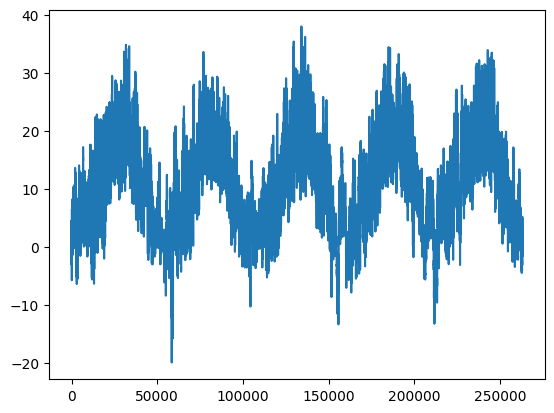

In [3]:
import matplotlib.pyplot as plt
plt.plot(range(len(df['T (degC)'])),df['T (degC)'])
plt.show()

- On this plot, you can clearly see the yearly periodicity of temperature.

Plot of the first ten days of temperature data

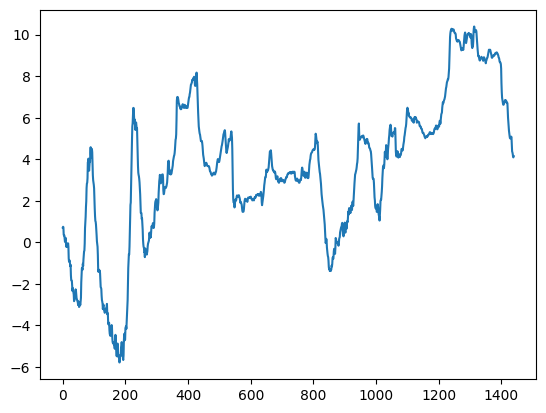

In [4]:
plt.plot(range(1440), df['T (degC)'][:1440])
plt.show()

## Preparing the data

The exact formulation of our problem will be the following: given data going as far back as *lookback* timesteps (a timestep is 10 minutes) and sampled every *steps* timesteps, can we predict the temperature in *delay* timesteps? 

We will use the following parameter values:

- lookback = 720, i.e. our observations will go back 5 days.
- steps = 6, i.e. our observations will be sampled at one data point per hour.
- delay = 144, i.e. our targets will be 24 hour in the future.
    
To get started, we need to do two things:

- Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so we don’t need to do any vectorization. However each timeseries in the data is one a different scale (e.g. temperature is typically between -20 and +30, but pressure, measured in mbar, is around 1000). So we will normalize each timeseries independently so that they all take small values on a similar scale.
- Write a Python generator that takes our current array of float data and yields batches of data from the recent past, alongside with a target temperature in the future. Since the samples in our dataset are highly redundant (e.g. sample N and N+1 sample will have most of their timesteps in common), it would be very wasteful to explicitly allocate every sample. Instead, we will generate the samples on the fly using the original data

In [6]:
# Normalizing the data
float_data=df.iloc[:,1:].values
mean=float_data[:100000,:].mean(axis=0)
float_data-=mean
std=float_data[:100000,:].std(axis=0)
float_data/=std

In [8]:
import numpy as np
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=100000, shuffle=True, step=step,  batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=100001, max_index=200000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=None, step=step, batch_size=batch_size)

In [9]:
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (200000 - 100001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 200001 - lookback) // batch_size

Before we start leveraging black-box deep learning models to solve our temperature prediction problem, let’s try out a simple common-sense approach. It will serve as a sanity check, and it will establish a baseline that we will have to beat in order to demonstrate the usefulness of more advanced machine learning models. 

In our case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as well as periodical with a daily period. Thus a common sense approach would be to always predict that the temperature 24 hours from now will be equal to the temperature right now. Let’s evaluate this approach, using the Mean Absolute Error metric (MAE). 

In [10]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.36559028802999083


- It yields a MAE of 0.37. Since our temperature data has been normalized to be centered on 0 and have a standard deviation of one, this number is not immediately interpretable. It translates to an average absolute error of 0.37 * temperature_std degrees Celsius, i.e. 7.95*0.37=2.94°C. That’s a fairly large average absolute error—now the game is to leverage our knowledge of deep learning to do better.

## A basic machine learning approach

- In the same way that it is useful to establish a common sense baseline before trying
machine learning approaches, it is useful to try simple and cheap machine learning
models (such as small densely-connected networks) before looking into complicated and
computationally expensive models such as RNNs. This is the best way to make sure that
any further complexity we throw at the problem later on is legitimate and delivers real
benefits.
- Here is a simply fully-connected model in which we start by flattening the data, then
run it through two layers. Note the lack of activation function on the last Dense Dense
layer, which is typical for a regression problem. We use MAE as the loss. Since we are
evaluating on the exact same data and with the exact same metric as with our common
sense approach, the results will be directly comparable

C:\Users\li\anaconda3\envs\LLM\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Epoch 1/20


C:\Users\li\anaconda3\envs\LLM\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 1.2902 - val_loss: 0.8864
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.3666 - val_loss: 0.5129
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.2637 - val_loss: 0.5257
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.2382 - val_loss: 0.5032
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.2227 - val_loss: 0.4954
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.2102 - val_loss: 0.5206
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.2007 - val_loss: 0.5317
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 0.1924 - val_loss: 0.5070
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 0.1862 - val_loss: 0.5237
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 0.1816 - val_loss: 0.5434
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.1760 - val_loss: 0.5023
Epoch 12/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 

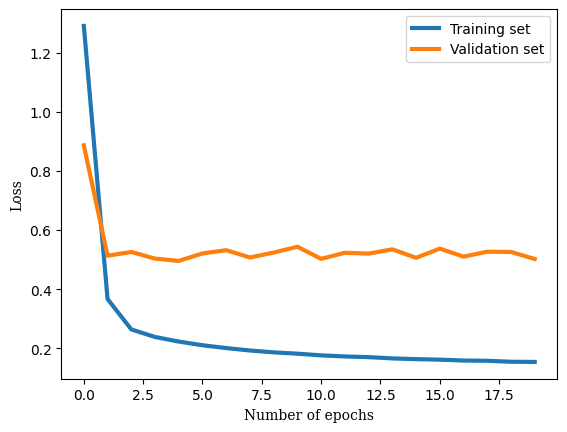

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)
history.history.keys()
def plot_fig(history):   
    #plt.figure(figsize=(10,4))
    plt.plot(range(len(history.history['loss'])),history.history['loss'],linewidth=3, label='Training set')
    plt.plot(range(len(history.history['loss'])),history.history['val_loss'],linewidth=3, label='Validation set')
    plt.xlabel("Number of epochs",fontdict= {'family':'serif','size':10})
    plt.ylabel("Loss",fontdict= {'family':'serif','size':10})
    plt.legend()
    plt.show()
plot_fig(history)

- Some of our validation losses get close to the no-learning baseline, but not very
reliably. This goes to show the merit of having had this baseline in the first place: it turns
out not to be so easy to outperform. Our common sense contains already a lot of valuable
information that a machine learning model does not have access to

## A first recurrent baseline

- Our first fully-connected approach didn’t do so well, but that doesn’t mean machine
learning is not applicable to our problem. The approach above consisted in first flattening
the timeseries, which removed the notion of time from the input data. Let us instead look
at our data as what it is: a sequence, where causality and order matter. We will try a
recurrent sequence processing model—it should be the perfect fit for such sequence data,
precisely because it does exploit the temporal ordering of data points, unlike our first
approach

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Input(shape=(None, float_data.shape[-1])))
model.add(layers.GRU(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)
plot_fig(history)

## Using recurrent dropout to fight overfitting

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Input(shape=(None, float_data.shape[-1])))
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)
plot_fig(history)

## Stacking recurrent layers

- Since we are no longer overfitting yet we seem to have hit a performance bottleneck, we should start considering increasing the capacity of our network. If you remember our description of the "universal machine learning workflow": it is a generally a good idea to increase the capacity of your network until overfitting becomes your primary obstacle (assuming that you are already taking basic steps to mitigate overfitting, such as using
dropout). As long as you are not overfitting too badly, then you are likely under-capacity.

- Increasing network capacity is typically done by increasing the number of units in the layers, or adding more layers. Recurrent layer stacking is a classic way to build more powerful recurrent networks: for instance, what currently powers the Google translate algorithm is a stack of seven large LSTM layers—that’s huge.

- To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at the last timestep. This is done by specifying *return_sequences=True*:

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Input(shape=(None, float_data.shape[-1])))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True))
model.add(layers.GRU(64, activation='relu', dropout=0.1,   recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)